In [52]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span
import networkx as nx
import matplotlib.pyplot as plt


In [53]:
#loading the models
nlp = spacy.load('en_core_web_sm')

## The pipe line assumes that the data is avalible by scrapping or textfile.

In [54]:
#The data to be processed
text = "Elon Musk is a business magnate, industrial designer, and engineer. He is the founder, CEO, CTO, and chief designer of SpaceX. He is also early investor, CEO, and product architect of Tesla, Inc. He is also the founder of The Boring Company and the co-founder of Neuralink. A centibillionaire, Musk became the richest person in the world in January 2021, with an estimated net worth of $185 billion at the time, surpassing Jeff Bezos. Musk was born to a Canadian mother and South African father and raised in Pretoria, South Africa. He briefly attended the University of Pretoria before moving to Canada aged 17 to attend Queen's University. He transferred to the University of Pennsylvania two years later, where he received dual bachelor's degrees in economics and physics. He moved to California in 1995 to attend Stanford University, but decided instead to pursue a business career. He went on co-founding a web software company Zip2 with his brother Kimbal Musk. Elon Musk has his sister Tosca Musk. Musk co-founded X.com. Musk became involved with the nonprofit Mars Society. Musk founded Space Exploration Technologies Corp.  Musk unveiled the concept. Musk has endowed prizes at the X Prize Foundation "

In [55]:
#splitting the data each sentance is an element
sentences = text.split(".")

In [56]:
#removing empty strings
sentences = [x for x in sentences if x != ""]

In [57]:
#replacing the He/he/Elon Musk ---> with "Musk" 
#to reduce the variaty of names
#we could use model like coreference to replace even pronoun with its noun but couldn't run it on colab

import re 

for i in range(len(sentences)):
  sentences[i] = re.sub("\W(he|He)\s|(^he|^He)\s", " Musk ", sentences[i])
  sentences[i]= sentences[i].replace("Elon Musk", "Musk")
  sentences[i]= sentences[i].replace("Elon", "Musk")

sentences

['Musk is a business magnate, industrial designer, and engineer',
 ' Musk is the founder, CEO, CTO, and chief designer of SpaceX',
 ' Musk is also early investor, CEO, and product architect of Tesla, Inc',
 ' Musk is also the founder of The Boring Company and the co-founder of Neuralink',
 ' A centibillionaire, Musk became the richest person in the world in January 2021, with an estimated net worth of $185 billion at the time, surpassing Jeff Bezos',
 ' Musk was born to a Canadian mother and South African father and raised in Pretoria, South Africa',
 " Musk briefly attended the University of Pretoria before moving to Canada aged 17 to attend Queen's University",
 " Musk transferred to the University of Pennsylvania two years later, where Musk received dual bachelor's degrees in economics and physics",
 ' Musk moved to California in 1995 to attend Stanford University, but decided instead to pursue a business career',
 ' Musk went on co-founding a web software company Zip2 with his brot

In [58]:
sentences

['Musk is a business magnate, industrial designer, and engineer',
 ' Musk is the founder, CEO, CTO, and chief designer of SpaceX',
 ' Musk is also early investor, CEO, and product architect of Tesla, Inc',
 ' Musk is also the founder of The Boring Company and the co-founder of Neuralink',
 ' A centibillionaire, Musk became the richest person in the world in January 2021, with an estimated net worth of $185 billion at the time, surpassing Jeff Bezos',
 ' Musk was born to a Canadian mother and South African father and raised in Pretoria, South Africa',
 " Musk briefly attended the University of Pretoria before moving to Canada aged 17 to attend Queen's University",
 " Musk transferred to the University of Pennsylvania two years later, where Musk received dual bachelor's degrees in economics and physics",
 ' Musk moved to California in 1995 to attend Stanford University, but decided instead to pursue a business career',
 ' Musk went on co-founding a web software company Zip2 with his brot

## Preparing the functions to extract entities and relations

In [59]:
#This function is used to get pairs of entities fro each sentence

def pair_entity(sent):
  ent1 = "" #subject entity
  ent2 = "" #object entity

  prev_token_text = "" #text from previous token
  prev_token_dep = ""  #depedency from previous token

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    #Go in only if it is not a punctuation, else next word
    if tok.dep_ != "punct":
      #Check if token is a compund word
      if tok.dep_ == "compound":
        prefix = tok.text
        #Check if previous token is also a compound
        if prev_token_dep == "compound":
          prefix = prev_token_text + " "+ prefix
      #Check if token is a modifier or not
      if tok.dep_.endswith("mod")==True:
        modifier = tok.text 
        #Check if previous token is a compound
        if prev_token_dep == "compound":
          modifier = prev_token_text + " " + modifier

      #Checking if subject
      if tok.dep_.find("subj") == True:
        ent1 =modifier+ " " + prefix + " " + tok.text
        prefix = ""
        modifer = ""
      #Checking if object
      if tok.dep_.find("obj") == True:
        ent2 =modifier+ " " + prefix + " " + tok.text
        prefix = ""
        modifer = ""

      #Update variables
      prev_token_text = tok.text
      prev_token_dep = tok.dep_

      ############################
  return [ent1.strip(), ent2.strip()]

In [60]:
#the function is for getting the relationship between each pair in each sentence.

def relation(txt):
  doc = nlp(txt)
  #We initialise matcher with the vocab
  matcher = Matcher(nlp.vocab)
  #Defining the pattern
  pattern = [{'DEP':'ROOT'},{'DEP':'prep','OP':'?'},{'DEP':'agent','OP':'?'},{'DEP':'ADJ','OP':'?'}]
  #Adding the pattern to the matcher
  matcher.add("matcher_1",None,pattern)
  #Applying the matcher to the doc
  matches = matcher(doc)

  #The matcher returns a list of (match_id, start, end). The start to end in our doc contains the relation. We capture that relation in a variable called span
  span = doc[matches[0][1]:matches[0][2]]
  return span.text

In [61]:
# Filling list of pairs of entities for each sentence
pairs = []
for i in sentences:
  pairs.append(pair_entity(i))

In [62]:
#getting the corresponding relation for each pair 
relations = [relation(row) for row in sentences]

In [63]:
#prepairing our data as a dataframe src/trg/relation 
src = [i[0] for i in pairs]
trg = [i[1] for i in pairs]

df = pd.DataFrame({'source':src, 'target':trg, 'edge':relations})

#Graph Representing

In [64]:
#using the networkx to represent our data as graph 
G=nx.from_pandas_edgelist(df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [65]:
#geting the dictionary to label the edges of the graph

dic = {}
for index, row in df.iterrows():
    dic[(row['source'], row['target'])] = row['edge']

dic

{('', ''): 'com',
 ('Musk', ''): 'is',
 ('Musk', 'African  Pretoria'): 'born',
 ('Musk', 'Exploration Technologies Corp'): 'founded',
 ('Musk', 'X Prize Foundation'): 'endowed',
 ('Musk', 'also  Neuralink'): 'is',
 ('Musk', 'briefly  University'): 'attended',
 ('Musk', 'brother'): 'went',
 ('Musk', 'chief  SpaceX'): 'is',
 ('Musk', 'concept'): 'unveiled',
 ('Musk', 'early product Tesla'): 'is',
 ('Musk', 'instead business career'): 'moved',
 ('Musk', 'nonprofit Mars Society'): 'became',
 ('Musk', 'sister'): 'has',
 ('centibillionaire  Musk', '$ Jeff Bezos'): 'became',
 ('where  Musk', 'dual  economics'): 'transferred'}

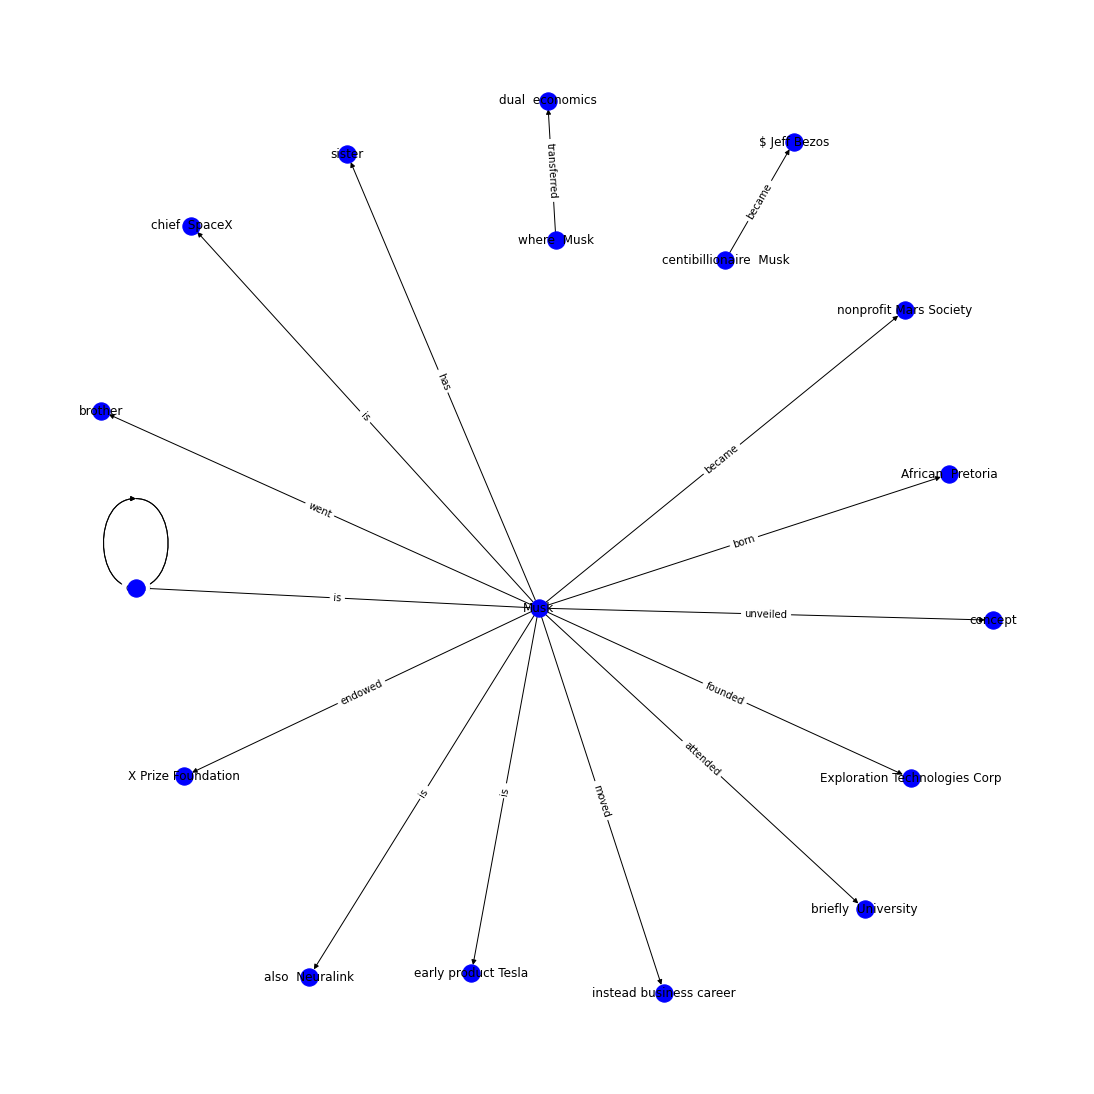

In [66]:
#Drawing the Graph and assigning the Labels to the edges.
plt.figure(figsize=(15,15))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='blue', edge_cmap=plt.cm.Blues, pos = pos)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=dic,
      
)
plt.show()